<a href="https://colab.research.google.com/github/TuanMiinh/BotAutoText/blob/master/Covid_Seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import print_function

import numpy as np
import os
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.python.keras.backend as KTF

from skimage.transform import resize
from keras.models import Model
from keras.layers import Input, concatenate, LeakyReLU, AveragePooling2D, Conv2D,ZeroPadding2D,Convolution2D, Conv2DTranspose,MaxPooling2D,add, UpSampling2D, multiply,Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.layers.core import Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from keras import backend as K,models
from skimage.io import imsave

In [3]:
def merge(inputs, mode, concat_axis=-1):
    return concatenate(inputs, concat_axis)

In [4]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code 此代码用于TF维度排序
smooth = 1.

img_rows =128
img_cols =128

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

data_path = '/content/gdrive/MyDrive/file2/file/'

In [5]:
def load_train_data():
    imgs_train = np.load(data_path + 'train.npy')
    imgs_mask_train = np.load(data_path + 'train_mask.npy')
    return imgs_train, imgs_mask_train

In [6]:
def load_validation_data():
    imgs_valid = np.load(data_path + 'validation.npy')
    imgs_mask_valid = np.load(data_path + 'validation_mask.npy')
    return imgs_valid, imgs_mask_valid


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)


In [7]:

def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())
#计算特异性
def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())

In [8]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.只计算批处理的平均精度。

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    计算精度，一个多标签分类的度量有多少选定的项目是相关的。
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [9]:
def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.仅计算批量平均召回率。

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        计算召回率，一个用于多标签分类的度量有多少相关的项目被选择。
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.只计算批处理的平均精度。

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        计算精度，一个多标签分类的度量有多少选定的项目是相关的。
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
 
    return 2*((precision*recall)/(precision+recall+K.epsilon()))   

In [10]:
def unet4(upsamezhi,chuandi,F_g, F_l,F_int):
    up = Conv2D(F_g, (1, 1), activation='relu', padding='same')(upsamezhi)
    up= BatchNormalization()(up)

    down= Conv2D(F_l, (1, 1), activation='relu', padding='same')(chuandi)
    down= BatchNormalization()(down)
    
    sumadd=add([up,down])
    sumadd = Activation(activation='relu')(sumadd)
    
    
    
    jihe=Conv2D(F_int, (1, 1), activation='relu', padding='same')(sumadd)
    sumhalf= BatchNormalization()(jihe)
    
    
    sum_1=Conv2D(1, (1, 1), activation='sigmoid', padding='same')(sumhalf)
    sum_1= BatchNormalization()(sum_1)
    
    xinchuandi=multiply([chuandi,sum_1])
    return xinchuandi


In [11]:
def bottleneck(x, filters_bottleneck, mode='cascade', nb_layers=1,
               kernel_size=(3, 3), activation='relu'):# used in the competition
    if mode == 'cascade':
        for i in range(nb_layers):
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation, 
               padding='same', dilation_rate=1)(x)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,
               padding='same', dilation_rate=2)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=4)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=8)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=16)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=1)(x1)
            
            x1 = Conv2D(filters_bottleneck, kernel_size,activation=activation,  
               padding='same', dilation_rate=1)(x1)
            
            x = concatenate([x, x1], axis=3)
        return x

In [12]:


def conv_block(x, nb_filter, alpha=0.0, drop_rate=0.2):
    
    x = Conv2D(nb_filter, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    
    x = Conv2D(nb_filter, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    
    if drop_rate: x = Dropout(drop_rate)(x)
    return x

In [13]:

def bottleneck_layer(x, nb_filter, nb_size = 4, alpha=0.0, drop_rate=0.2): #nb_size = 4,
    
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(nb_size*nb_filter, kernel_size=(1, 1), padding='same', strides=(1, 1))(x)   #nb_size*
    
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(nb_filter, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    
    if drop_rate: x = Dropout(drop_rate)(x)
    
    return x

In [14]:
def Dense_Block(x, growth_rate, nb_layers=1, drop_rate=0.2):  #Dense_Block(x, nb_layers, growth_rate, drop_rate=0.2)
    
    for i in range(nb_layers):
        conv = bottleneck_layer(x, nb_filter=growth_rate, drop_rate=drop_rate)
        x = concatenate([x, conv], axis=3)
        return x

In [15]:
def TransitionLayer(x, compression=0.5, alpha=0.0, is_max=0):
    
    nb_filter = int(x.shape.as_list()[-1]*compression)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    x = Conv2D(nb_filter, (1, 1), strides=(1,1), padding='same')(x)
    if is_max != 0: x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    else: x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    
    return x

In [16]:
def encoder(x):
    to_decoder = []
    #128*128*32    first branching to decoder
    main_path = conv_block(x, 32, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #64*64*64      second branching to decoder
    main_path = TransitionLayer(main_path, is_max =1)
    main_path = conv_block(main_path, 64, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #32*32*128     third branching to decoder
    main_path = TransitionLayer(main_path, is_max =1)
    main_path = conv_block(main_path, 128, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #16*16*256     fourth branching to decoder
    main_path = TransitionLayer(main_path, is_max =1)
    main_path = conv_block(main_path, 256, drop_rate=0.2)
    to_decoder.append(main_path)
    
    #8*8*512
    main_path = TransitionLayer(main_path, is_max=0)
    main_path = Dense_Block(main_path, 512, drop_rate=0.2)
    to_decoder.append(main_path)
    return to_decoder


def decoder(x, from_encoder):#
    #8*8*256
    main_path = UpSampling2D(size=(2, 2))(x)  
    xin_encoder_1 = unet4(main_path,from_encoder[4],256, 256,128)#
    main_path = concatenate([main_path, xin_encoder_1], axis=3)
    main_path = Dense_Block(main_path, 512, drop_rate=0.2)
    # 
    #16*16*128
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_2 = unet4(main_path,from_encoder[3],128, 128,64)
    main_path = concatenate([main_path, xin_encoder_2], axis=3)
    main_path = conv_block(main_path, 256, drop_rate=0.2)
    
    #32*32*64
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_3 = unet4(main_path,from_encoder[2],64, 64,32)
    main_path = concatenate([main_path, xin_encoder_3], axis=3)
    main_path = conv_block(main_path, 128, drop_rate=0.2)
    
    #64*64*32
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_4 = unet4(main_path,from_encoder[1],32, 32,16)
    main_path = concatenate([main_path, xin_encoder_4], axis=3)
    main_path = conv_block(main_path, 64, drop_rate=0.2)
    
    #128*128*16
    main_path = UpSampling2D(size=(2, 2))(main_path)
    xin_encoder_5 = unet4(main_path,from_encoder[0],16, 16,8)
    main_path = concatenate([main_path, xin_encoder_5], axis=3)
    main_path = conv_block(main_path, 32, drop_rate=0.2)
    
    return main_path


def build_res_unet( ):
    #inputs = Input(shape=input_shape)
    inputs = Input(shape=(img_rows, img_cols, 1)) #128*128*1

    to_decoder = encoder(inputs)
    
    path = TransitionLayer(to_decoder[4], is_max=0)
    path = Dense_Block(path, 512, drop_rate=0.2) #4*4*512
    
    bottle = bottleneck(path, filters_bottleneck=256, mode='cascade')#4*4*256
    
    path1 = Dense_Block(bottle, 256, drop_rate=0.2) #4*4*256
    
    path = decoder(path1, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='hard_sigmoid',padding='same')(path)#activation='hard_sigmoid'可改为activation='softmax'
    
    model=Model(inputs=inputs, outputs=path)
    

             
    model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy',dice_coef, sensitivity,specificity,f1score,precision])

    return model
    

In [17]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


In [ ]:
def train():
    print('-' * 30)
    print('Loading and preprocessing train data...')
    print('-' * 30)
    imgs_train, imgs_mask_train = load_train_data()
    imgs_valid, imgs_mask_valid = load_validation_data()

    imgs_train = preprocess(imgs_train)
    print(imgs_train.shape)
    imgs_mask_train = preprocess(imgs_mask_train)
    print(imgs_mask_train.shape)
    imgs_valid = preprocess(imgs_valid)
    print(imgs_valid.shape)
    imgs_mask_valid = preprocess(imgs_mask_valid)
    print(imgs_mask_valid.shape)

    imgs_train = imgs_train.astype('float32')
    imgs_valid = imgs_valid.astype('float32')

    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    val_mean = np.mean(imgs_valid)
    val_std = np.std(imgs_valid)

    imgs_train -= mean
    imgs_train /= std

    imgs_valid -= val_mean
    imgs_valid /= val_std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    imgs_mask_valid = imgs_mask_valid.astype('float32')
    imgs_mask_valid /= 255.

    print('-' * 30)
    print('Creating and compiling model...')
    print('-' * 30)
    model =build_res_unet()
    model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/file2/file/ADIDC-Net-again.hdf5',
                                       monitor='val_loss',
                                       save_best_only=True)
    
    

    # print('-' * 30)
    # print('Fitting model...')
    # print('-' * 30)
    # #earlystopper=EarlyStopping(monitor='val_loss',patience=10,verbose=1)
    # his = model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=300, verbose=1, shuffle=True,
    #                 validation_data=(imgs_valid, imgs_mask_valid), callbacks=[model_checkpoint])
  
    
    # score_1=model.evaluate(imgs_train,imgs_mask_train,batch_size=32,verbose=1)
    # print(' Train loss:',score_1[0])
    # print(' Train accuracy:',score_1[1])
    # print(' Train dice_coef:',score_1[2])
    # print(' Train sensitivity:',score_1[3])
    # print(' Train specificity:',score_1[4])
    # print(' Train f1score:',score_1[5])
    # print('Train precision:',score_1[6])
    # res_loss_1 = np.array(score_1)
    # np.savetxt(data_path+ 'res_loss_1.txt', res_loss_1)
    
    # score_2=model.evaluate(imgs_valid,imgs_mask_valid,batch_size=32, verbose=1)
    # print(' valid loss:',score_2[0])
    # print(' valid  accuracy:',score_2[1])
    # print(' valid  dice_coef:',score_2[2])
    # print(' valid  sensitivity:',score_2[3])
    # print(' valid  specificity:',score_2[4])
    # print(' valid f1score:',score_2[5])
    # print('valid  precision:',score_2[6])
    # res_loss_2 = np.array(score_2)
    # np.savetxt(data_path + 'res_loss_2.txt', res_loss_2)

    # plt.plot()
    # plt.plot(his.history['loss'], label='train loss')
    # plt.plot(his.history['val_loss'], c='g', label='val loss')
    # plt.title('train and val loss')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # plt.legend(loc='upper right')
    # plt.show()
    
    
    # plt.plot()
    # plt.plot(his.history['acc'], label='train accuracy')    #'acc'
    # plt.plot(his.history['val_acc'], c='g', label='val accuracy')   #'val_acc'
    # plt.title('train  and val acc')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # plt.legend(loc='lower right')
    # plt.show()
    
    # plt.plot()
    # plt.plot(his.history['dice_coef'], label='train dice_coef')
    # plt.plot(his.history['val_dice_coef'], c='g', label='val dice_coef')
    # plt.title('train  and val dice_coef')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # plt.legend(loc='lower right')
    # plt.show()
    
        
    # plt.plot()
    # plt.plot(his.history['sensitivity'], label='train sensitivity')
    # plt.plot(his.history['val_sensitivity'], c='g', label='val sensitivity')
    # plt.title('train  and val sensitivity')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # plt.legend(loc='lower right')
    # plt.show()
       
    # plt.plot()
    # plt.plot(his.history['specificity'], label='train specificity')
    # plt.plot(his.history['val_specificity'], c='g', label='val specificity')
    # plt.title('train  and val specificity')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # plt.legend(loc='lower right')
    # plt.show()
    
    
    

    
    # plt.plot()
    # plt.plot(his.history['f1score'], label='train f1score')
    # plt.plot(his.history['val_f1score'], c='g', label='val f1score')
    # plt.title('train  and val f1score')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # plt.legend(loc='lower right')
    # plt.show()
    
   
    # plt.plot()
    # plt.plot(his.history['precision'], label='train precision')
    # plt.plot(his.history['val_precision'], c='g', label='val_precision')
    # plt.title('train  and val precision')
    # plt.xlabel('epoch')
    # plt.ylabel('accuracy')
    # plt.legend(loc='lower right')
    # plt.show()

In [ ]:
print('-' * 30)
print('Loading and preprocessing train data...')
print('-' * 30)
imgs_train, imgs_mask_train = load_train_data()
imgs_valid, imgs_mask_valid = load_validation_data()

imgs_train = preprocess(imgs_train)
print(imgs_train.shape)
imgs_mask_train = preprocess(imgs_mask_train)
print(imgs_mask_train.shape)
imgs_valid = preprocess(imgs_valid)
print(imgs_valid.shape)
imgs_mask_valid = preprocess(imgs_mask_valid)
print(imgs_mask_valid.shape)

imgs_train = imgs_train.astype('float32')
imgs_valid = imgs_valid.astype('float32')

mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

val_mean = np.mean(imgs_valid)
val_std = np.std(imgs_valid)

imgs_train -= mean
imgs_train /= std

imgs_valid -= val_mean
imgs_valid /= val_std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

imgs_mask_valid = imgs_mask_valid.astype('float32')
imgs_mask_valid /= 255.

print('-' * 30)
print('Creating and compiling model...')
print('-' * 30)
model =build_res_unet()
model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/file2/file/ADIDC-Net-again.hdf5',
                                       monitor='val_loss',
                                       save_best_only=True)
    
    

print('-' * 30)
print('Fitting model...')
print('-' * 30)
#earlystopper=EarlyStopping(monitor='val_loss',patience=10,verbose=1)
his = model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=300, verbose=1, shuffle=True,
                    validation_data=(imgs_valid, imgs_mask_valid), callbacks=[model_checkpoint])
  
    
score_1=model.evaluate(imgs_train,imgs_mask_train,batch_size=32,verbose=1)
print(' Train loss:',score_1[0])
print(' Train accuracy:',score_1[1])
print(' Train dice_coef:',score_1[2])
print(' Train sensitivity:',score_1[3])
print(' Train specificity:',score_1[4])
print(' Train f1score:',score_1[5])
print('Train precision:',score_1[6])
res_loss_1 = np.array(score_1)
np.savetxt(data_path+ 'res_loss_1.txt', res_loss_1)
    
score_2=model.evaluate(imgs_valid,imgs_mask_valid,batch_size=32, verbose=1)
print(' valid loss:',score_2[0])
print(' valid  accuracy:',score_2[1])
print(' valid  dice_coef:',score_2[2])
print(' valid  sensitivity:',score_2[3])
print(' valid  specificity:',score_2[4])
print(' valid f1score:',score_2[5])
print('valid  precision:',score_2[6])
res_loss_2 = np.array(score_2)
np.savetxt(data_path + 'res_loss_2.txt', res_loss_2)

# plt.plot()
# plt.plot(his.history['loss'], label='train loss')
# plt.plot(his.history['val_loss'], c='g', label='val loss')
# plt.title('train and val loss')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(loc='upper right')
# plt.show()
    
    
# plt.plot()
# plt.plot(his.history['accuracy'], label='train accuracy')    #'acc'
# plt.plot(his.history['val_acc'], c='g', label='val accuracy')   #'val_acc'
# plt.title('train  and val acc')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(loc='lower right')
# plt.show()
    
# plt.plot()
# plt.plot(his.history['dice_coef'], label='train dice_coef')
# plt.plot(his.history['val_dice_coef'], c='g', label='val dice_coef')
# plt.title('train  and val dice_coef')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(loc='lower right')
# plt.show()
    
        
# plt.plot()
# plt.plot(his.history['sensitivity'], label='train sensitivity')
# plt.plot(his.history['val_sensitivity'], c='g', label='val sensitivity')
# plt.title('train  and val sensitivity')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(loc='lower right')
# plt.show()
       
# plt.plot()
# plt.plot(his.history['specificity'], label='train specificity')
# plt.plot(his.history['val_specificity'], c='g', label='val specificity')
# plt.title('train  and val specificity')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(loc='lower right')
# plt.show()
    
    
    

    
# plt.plot()
# plt.plot(his.history['f1score'], label='train f1score')
# plt.plot(his.history['val_f1score'], c='g', label='val f1score')
# plt.title('train  and val f1score')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(loc='lower right')
# plt.show()
    
   
# plt.plot()
# plt.plot(his.history['precision'], label='train precision')
# plt.plot(his.history['val_precision'], c='g', label='val_precision')
# plt.title('train  and val precision')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(loc='lower right')
# plt.show()

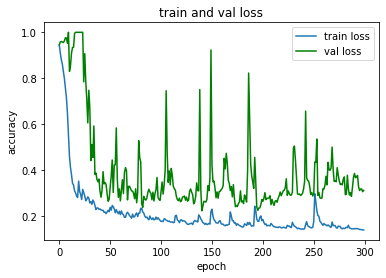

In [ ]:
import matplotlib.pyplot as plt


plt.plot()
plt.plot(his.history['loss'], label='train loss')
plt.plot(his.history['val_loss'], c='g', label='val loss')
plt.title('train and val loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.show()
    

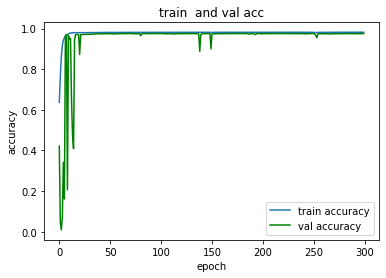

In [ ]:
    
plt.plot()
plt.plot(his.history['accuracy'], label='train accuracy')    #'acc'
plt.plot(his.history['val_accuracy'], c='g', label='val accuracy')   #'val_acc'
plt.title('train  and val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
import numpy as np
from PIL import Image
import os
from skimage.transform import resize
from keras.models import model_from_json
import cv2

In [19]:
data_path ='/content/gdrive/MyDrive/file2/file/'

In [20]:
def load_train_data():
    imgs_train = np.load(data_path + 'train.npy')
    imgs_mask_train = np.load(data_path + 'train_mask.npy')
    return imgs_train, imgs_mask_train

def load_test_data():
    imgs_test = np.load(data_path + 'test.npy')
    imgs_mask_test = np.load(data_path + 'test_mask.npy')
    return imgs_test, imgs_mask_test

In [21]:
path = '/content/gdrive/MyDrive/file2/file/lr-5-32-100/'

In [22]:
img_predict = r'/content/gdrive/MyDrive/file2/file/lr-5-32-100/UNET_PREDICTIONS/Test_Image_1_Predict.png' 

In [23]:
def convert(URL):
    image_rows = 128
    image_cols = 128
    imgs = np.ndarray((1, image_rows, image_cols), dtype=np.uint8)
    i = 0
    img = cv2.imread(URL, cv2.IMREAD_GRAYSCALE)  #
    img = np.array([img])
    imgs[i] = img
    np.save(data_path + '/covert1.npy', imgs)
    print("Successs")

In [24]:
def predict():
    model = build_res_unet()
    # print (model.metrics_names)
    # imgs_train, imgs_mask_train = load_train_data()

    path_to_save_results= path+"UNET_PREDICTIONS/"

    # imgs_train = preprocess(imgs_train)
    # imgs_mask_train = preprocess(imgs_mask_train)
    #
    # # mean= np.mean(img)
    # # std = np.std(imgs_mask_train)

    # imgs_test, imgs_test_mask = load_test_data()

    imgs_test = np.load('/content/gdrive/MyDrive/file2/file/covert1.npy')


    mean = np.mean(imgs_test)
    std = np.std(imgs_test)
    # print(std)

    imgs_test = preprocess(imgs_test)
    # imgs_test_mask = preprocess(imgs_test_mask)

    imgs_test_source = imgs_test.astype('float32')
    imgs_test_source -= mean
    imgs_test_source /= std

    # imgs_test_mask = imgs_test_mask.astype('float32')
    # imgs_test_mask /= 255.  # scale masks to [0, 1]

    print('Loading saved weights...')
    print('-'*30)
    
    model.load_weights(data_path +'ADIDC-Net-again.hdf5')
   
    
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_predict = model.predict(imgs_test_source, verbose=1)
    # res = model.evaluate(imgs_test_source,imgs_test_mask,batch_size=32,verbose=1)
    # print(' Test loss:',res[0])
    
    # #print(' Test sensitivity:',res[1])
    # print('Test accuracy:',res[1])
    #
    # #print(' Test specificity:',res[2])
    # print(' Test dice_coef:',res[2])
    #
    # #print('Test f1score:',res[3])
    # print(' Test sensitivity:',res[3])
    #
    # #print(' Test precision:',res[4])
    # print(' Test specificity:',res[4])
    #
    # #print(' Test mean_iou:',res[5])
    # print('Test f1score:',res[5])
    #
    # #print('Test recall:',res[6])
    # print(' Test precision:',res[6])
    #
    
    # res_loss = np.array(res)
    # np.save(path+'predict.npy', imgs_mask_predict)
    # np.savetxt(path + 'res_loss.txt', res_loss)
    #
    # predicted_masks=np.load(path+'predict.npy')
    predicted_masks = imgs_mask_predict
    predicted_masks*=255
    # imgs_test, imgs_test_mask = load_test_data()

    for i in range(imgs_test.shape[0]):
        # img = resize(imgs_test[i], (128, 128), preserve_range=True)
        # img_mask = resize(imgs_test_mask[i], (128, 128), preserve_range=True)
        # im_test_source = Image.fromarray(img.astype(np.uint8))
        # im_test_masks = Image.fromarray((img_mask.squeeze()).astype(np.uint8))
        im_test_predict = Image.fromarray((predicted_masks[i].squeeze()).astype(np.uint8))
        im_test_source_name = "Test_Image_"+str(i+1)+".png"
        im_test_predict_name = "Test_Image_"+str(i+1)+"_Predict.png"
        im_test_gt_mask_name = "Test_Image_"+str(i+1)+"_OriginalMask.png"
        # im_test_source.save(os.path.join(path_to_save_results,im_test_source_name))
        im_test_predict.save(os.path.join(path_to_save_results,im_test_predict_name))
        # im_test_masks.save(os.path.join(path_to_save_results,im_test_gt_mask_name))
    message="Successfully Saved Results to "+path_to_save_results
    print (message)
    x = cv2.imread(img_predict)
    converted = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
    plt.imshow(x)
    plt.show()



In [25]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  


Saving 2_0_5423.tif to 2_0_5423.tif
User uploaded file "2_0_5423.tif" with length 12510 bytes


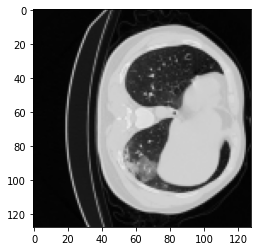

In [26]:
img = list(uploaded.keys())[0]
x = cv2.imread(img)
converted = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
# x = cv2.resize(converted,(512,512))[:,:,0]

plt.imshow(x)
plt.show()

Successs
Loading saved weights...
------------------------------
Predicting masks on test data...
------------------------------
1/1 [==============================] - 17s 17s/step
Successfully Saved Results to /content/gdrive/MyDrive/file2/file/lr-5-32-100/UNET_PREDICTIONS/


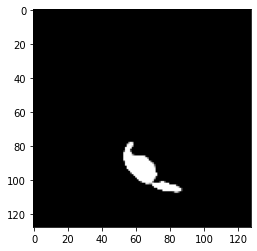

In [27]:
if __name__ == '__main__':
    convert(img)
    predict()
    # model = build_res_unet( )
    # print (model.metrics_names)
    
# x = cv2.resize(cv2.imread(img),(512,512))[:,:,0]


In [ ]:
pip install Flask-Cors==1.10.3

In [ ]:
!pip install flask-ngrok

In [ ]:
import base64

import cv2
import numpy as np
from flask import Flask,render_template
from flask import request
from flask_cors import CORS, cross_origin
from flask_ngrok import run_with_ngrok

In [ ]:
app = Flask(__name__,template_folder='/content/gdrive/MyDrive/MiAI_Face_Shape/templates')
app.config['UPLOAD_FOLDER'] = "/content/gdrive/MyDrive/MiAI_Face_Shape/static"

In [ ]:
@app.route('/', methods=['POST','GET'])
def home():
  if request.method == "GET":
    return render_template("index.html")
  return "Home"
# def covid_detect_process():
#     a = request.form.get("a")
#     b = request.form.get("b")

#     return str(a+b)

In [ ]:
@app.route('/CovidDetect', methods=['POST'])
# @cross_origin(origin='*')
def covid_detect_process():
    lung_base64 = request.form.get('lung_base64')

    lung_img = convert_base64_to_img(lung_base64)


    return "hehehe"

In [ ]:
if __name__ == '__main__':
    run_with_ngrok(app) 
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://343322f17633.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [13/Apr/2021 10:52:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Apr/2021 10:52:28] "GET /static/tet_back.png HTTP/1.1" 404 -
127.0.0.1 - - [13/Apr/2021 10:52:29] "GET /favicon.ico HTTP/1.1" 404 -
